In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import mplfinance as mpl

## Downloading Data from yfinance

In [2]:
data = yf.download("BAJFINANCE.NS", start = '2013-07-13', end = '2023-07-13')

[*********************100%***********************]  1 of 1 completed


## Finding the Local Extremas using scipy

In [3]:
arr = data.Close.to_numpy()
bottoms = (argrelextrema(arr, np.less, order=3)[0])
tops = (argrelextrema(arr, np.greater, order=3)[0])
ext_index = np.hstack((bottoms, tops))
ext_index = np.sort(ext_index)
df = data.Close[ext_index]
df = pd.DataFrame(df)
print(df) 

                  Close
Date                   
2013-08-07   101.610001
2013-08-13   124.400002
2013-08-28    98.425003
2013-09-04    98.580002
2013-09-11   116.529999
...                 ...
2023-06-06  7113.950195
2023-06-08  7010.100098
2023-06-19  7386.200195
2023-06-23  6989.649902
2023-07-04  7860.450195

[480 rows x 1 columns]


## Finding where the Double bottom and top is formed

In [4]:
def find_pattern(extrema):
    
    double_tops = []
    double_bottoms = []

    # period range is 5 units
    for i in range(5, len(extrema)):  
        period = extrema.iloc[i-5:i]
        
        if period.index[-1] - period.index[0] > 50:      
            continue   
            
        a, b, c, d, e = period.iloc[0:5].Close
     
        if a<b and a<d and c<b and c<d and e<b and e<d and b>d :
               double_tops.append((period.index[0], period.index[1], period.index[2], period.index[-2], period.index[-1]))

        if a>b and a>d and c>b and c>d and e>b and e>d and b<d:
                double_bottoms.append((period.index[0], period.index[1], period.index[2], period.index[-2], period.index[-1]))

    return double_tops, double_bottoms


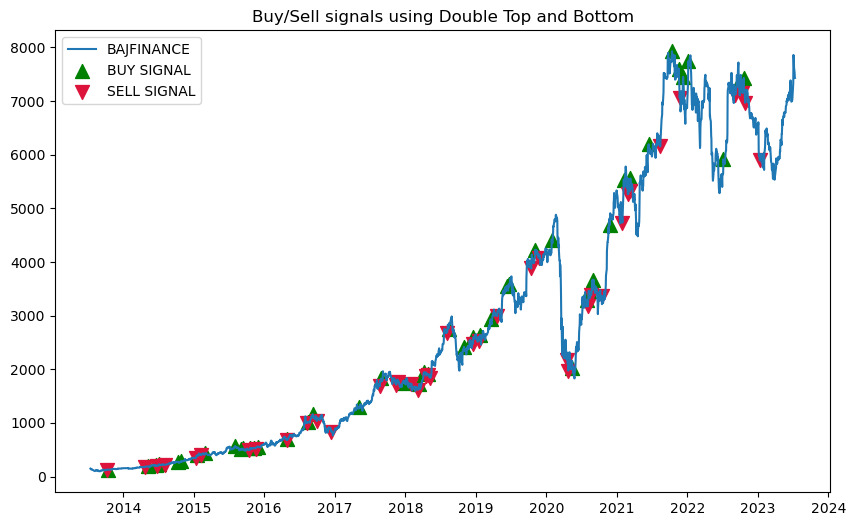

In [5]:
df1 = df.set_index(ext_index)
dt, db = find_pattern(df1)
signal_buy = [x[-1] for x in db]
signal_sell = [x[-1] for x in dt]
plt.figure(figsize = (10,6))
plt.plot(data.index, data['Close'], alpha = 1, label = 'BAJFINANCE')
plt.scatter(data.index[signal_buy], data.Close[signal_buy], marker = '^', s = 100, color = 'green', label = 'BUY SIGNAL')
plt.scatter(data.index[signal_sell], data.Close[signal_sell], marker = 'v', s = 100, color = 'crimson', label = 'SELL SIGNAL')
plt.legend(loc = 'upper left')
plt.title('Buy/Sell signals using Double Top and Bottom')
plt.show()

In [6]:
def Bollinger(data, n1 = 20, multiplier = 2):
    MA = data.Close.rolling(window=n1).mean()
    SD = data.Close.rolling(window=n1).std()
    data['bbmb'] = MA
    data['bbub'] = MA + (multiplier * SD) 
    data['bblb'] = MA - (multiplier * SD)
    

### Bollinger Bands (Plot is for last 1 year for clearer graph)

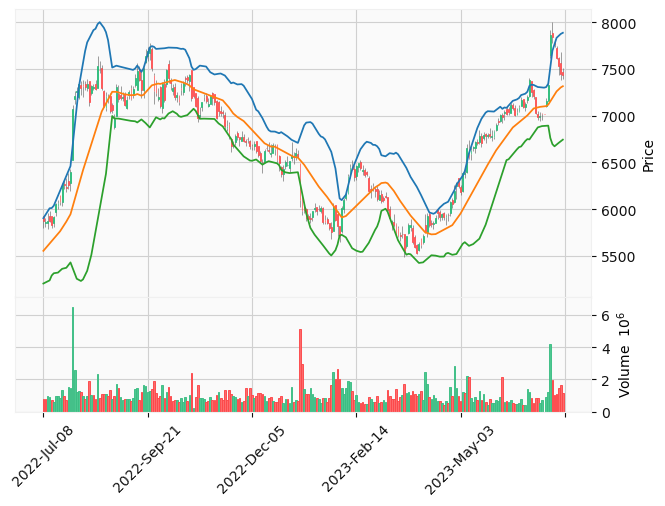

In [7]:
Bollinger(data,20,2)
data2 = data[-250:]
apd = mpl.make_addplot(data2[['bbub', 'bbmb', 'bblb']])
mpl.plot(data2, type="candle", addplot=apd, style = "yahoo", volume=True)

In [8]:
def Trade_BOLLINGER(data):
    buy, sell = [], []
    flag = 0
    for i in range(2, len(data)):
        if flag == 1 and data.Close.iloc[i] > data.bbub.iloc[i] and data.Close.iloc[i - 1] < data.bbub.iloc[i - 1]:
            sell.append(i)
            flag = 0
        elif flag == 0 and data.Close.iloc[i] < data.bblb.iloc[i] and data.Close.iloc[i - 1] > data.bblb.iloc[i - 1]:
            buy.append(i)
            flag = 1
    if len(sell) != 0 and len(buy) != 0:
        if sell[0] < buy[0]:
            sell.pop(0)
        if buy[-1] > sell[-1]:
            buy.pop(-1)
    return (buy, sell)

## Trading Signals generated by Bollinger Bands 

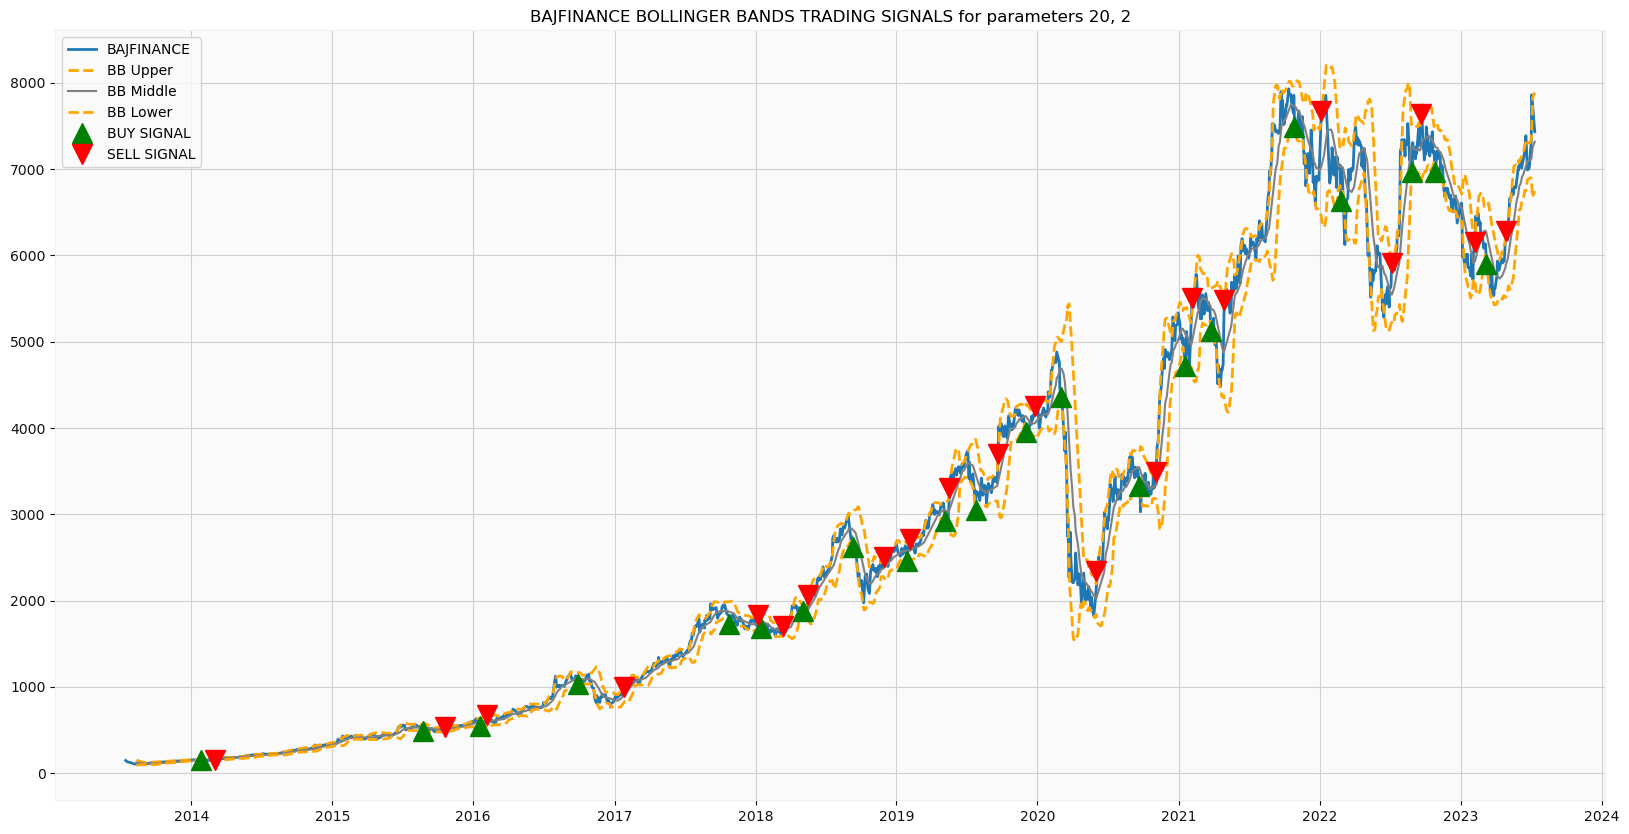

In [9]:
buy1, sell1 = Trade_BOLLINGER(data)
plt.figure(figsize=(20,10))
plt.plot(data['Close'], linewidth = 2, label = 'BAJFINANCE')
plt.plot(data.bbub, linewidth = 2, color = 'orange', linestyle = '--', label = 'BB Upper')
plt.plot(data.bbmb, linewidth = 1.5, color = 'grey', label = 'BB Middle')
plt.plot(data.bblb, linewidth = 2, color = 'orange', linestyle = '--', label = 'BB Lower')
plt.plot(data.index[buy1], data.Close[buy1], marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(data.index[sell1], data.Close[sell1], marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'upper left')
plt.title('BAJFINANCE BOLLINGER BANDS TRADING SIGNALS for parameters 20, 2')
plt.show()

### Function to find where both BB and Chart Pattern generate same signal

In [10]:
def Trade_Signal(data, dt, db):
    buy, sell = [], []
    for i in range(len(dt)):
        if data.Close[dt[i][1]] > data.bbub[dt[i][1]] and data.Close[dt[i][3]] < data.bbub[dt[i][3]]:
            sell.append(dt[i])
    for i in range(len(db)):
        if data.Close[db[i][1]] < data.bblb[db[i][1]] and data.Close[db[i][3]] > data.bblb[db[i][3]]:
            buy.append(db[i])
    return (buy, sell)

### Calculating the returns when we trade on the final signals generated

In [11]:
def get_pattern_return(data, dtdb, x, capital):
    entry_price = data.Close[dtdb[0][-1]]
    entry_i = dtdb[0][-1]
    stop_price = data.Close[dtdb[0][1]]

    if x:
        tp_price = entry_price + (data.Close[dtdb[0][0]] - data.Close[dtdb[0][1]])
    else:
        tp_price = entry_price - (data.Close[dtdb[0][1]] - data.Close[dtdb[0][0] ])

    exit_price = -1
    for i in range(dtdb[0][-1] - dtdb[0][0]):
        if entry_i + i >= len(data):
            return np.nan

        exit_price = data.Close[entry_i + i]
        if  x and (exit_price > tp_price or exit_price < stop_price):
            break
        
        if not x and (exit_price < tp_price or exit_price > stop_price):
            break
    
    if x: # Long
        return capital *(1 + (exit_price - entry_price) / entry_price)
    else: # Short
        return capital *(1 - (exit_price - entry_price) / entry_price)

In [12]:
returns = []
Bollinger(data,19,1.5)
buy, sell = Trade_Signal(data, dt, db)
capital = 50
for i in range(len(buy)):
    capital = get_pattern_return(data, buy[i:], 1, capital)

capital1 = 50
for i in range(len(sell)):
     capital1 = get_pattern_return(data, sell[i:], 0, capital)
        
returns.append(capital + capital1 - 100)

print("Maximum Returns by trading on signals generated by BB and Double Bottom/Top Chart Pattern =", max(returns))
Roll_Max = data['Adj Close'].cummax()
Daily_Drawdown = data['Adj Close']/Roll_Max - 1.0
Max_Daily_Drawdown = Daily_Drawdown.min()
print("MAX Drawdown =",Max_Daily_Drawdown)
daily_return = data['Adj Close'].pct_change().dropna()
sharpe = ((daily_return.mean())/daily_return.std())*np.sqrt(252)
print("Sharpe Ratio =", sharpe)

Maximum Returns by trading on signals generated by BB and Double Bottom/Top Chart Pattern = 7.072976332537834
MAX Drawdown = -0.6243781276628886
Sharpe Ratio = 1.2599649469280538
